In [1]:
import torch
import torch_geometric
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from tqdm.notebook import tqdm
import numpy as np

In [2]:
import yaml

with open('definitions.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)
    
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']

In [3]:
labels

['label_QCD_b',
 'label_QCD_bb',
 'label_QCD_c',
 'label_QCD_cc',
 'label_QCD_others',
 'sample_isQCD',
 'label_H_bb']

In [4]:
from GraphDataset import GraphDataset
#file_names = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.root']
file_names = ['/teams/DSC180A_FA20_A00/b06particlephysics/train/ntuple_merged_10.root']

graph_dataset = GraphDataset('gdata_train', features, labels, spectators, n_events=1000, n_events_merge=1, 
                             file_names=file_names)

# let's make use of the multiclassification
# this method will make sure that our data is labeled by a one-hot encoding 6d vector (for the 6 classes)
graph_dataset.process()


1000


# Understanding the data:

In [5]:
graph_dataset   # contains 917 graphs (jets)

GraphDataset(917)

In [6]:
graph_dataset[0]         # let's explore the first jet

# edge_index: it contains a tensor of edge connections that connects 462 tracks together (462=22*21 .. as we assume all 22 tracks of this jet are connected to each other)
# u : just a global feature don't worry about it now
# x : it has 13 tracks, each track has 48 features
# y : it is a (1,6) tensor that is a one-hot encoder specefying the class of the jet

[Data(edge_index=[2, 462], u=[1, 2], x=[22, 48], y=[1, 6])]

In [7]:
# To better understand the edge_index:
graph_dataset[0][0].edge_index

# this is an edge_index tensor which is always of the form of 2 lists (call them listA and listB)
# each element in listA represents a node.. 0 means 1st node, 21 means 22nd node (same for listB)
# the idea is that: there is a connection between listA[i] and listB[i] for all i
# as you can see from the first 3 elements: the 1st node is connected to the 2nd,3rd,4th.. (but not to itself, so listB doesnt have a 0 as first element)
# as you can see from the last 3 elements: the 22nd node is connected to the 19th,20th,21st.. (but not to itself, so listB doesnt have a 21 as last element)

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,
          5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
          6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
          6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,
          9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 10,

In [8]:
graph_dataset[0][0].y     # this jet is from one class

tensor([[0, 0, 0, 0, 1, 0]])

In [9]:
graph_dataset[1][0].y     # this jet is from the other class

tensor([[0, 0, 0, 1, 0, 0]])

# Understanding a pytorch "Dataloader":

In [10]:
### a dataloader is usually the datatype you want to deal with in pytorch..
### it helps you to iterate over your data in an orderly manner

In [11]:
from torch_geometric.data import Data, DataListLoader, Batch
from torch.utils.data import random_split

def collate(items):
    l = sum(items, [])
    return Batch.from_data_list(l)

torch.manual_seed(0)
valid_frac = 0.20
full_length = len(graph_dataset)
valid_num = int(valid_frac*full_length)
batch_size = 32

train_dataset, valid_dataset = random_split(graph_dataset, [full_length-valid_num,valid_num])

train_loader = DataListLoader(graph_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
train_loader.collate_fn = collate
valid_loader = DataListLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
valid_loader.collate_fn = collate

train_samples = len(train_dataset)
valid_samples = len(valid_dataset)

In [12]:
print(train_samples)     # we divide the 1000 graphs as 80%->train and 20%->valid
print(valid_samples)

734
183


In [13]:
# notice now this is the type of the data object that we will feed to the neural network
type(train_loader)

torch_geometric.data.dataloader.DataListLoader

In [14]:
# this object is iterable as follows
next(iter(train_loader))                # each time you run this cell you will get a new batch
                                        # each batch contains 32 jets
                                        # 888 is the number of tracks in those 32 jets combined

Batch(batch=[888], edge_index=[2, 28230], u=[32, 2], x=[888, 48], y=[32, 6])

In [15]:
# you can also iterate over this object via a for loop (this is how we do the training) 
# each batch contains many jets.. for ex: first batch contains 32 jets

for batch in train_loader:
    print(batch)
    break

Batch(batch=[972], edge_index=[2, 33834], u=[32, 2], x=[972, 48], y=[32, 6])


In [16]:
# you can access what is inside the iterator as follows.. here i am accessing the y (label) for the 32 jets 
for batch in train_loader:
    print(batch.y)
    print(batch.y.shape)
    break

tensor([[0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0]])
torch.Size([32, 6])


In [17]:
# you can also use an "enumerate" to retrieve a batch index along with the batch
t = enumerate(train_loader)
for i,batch in t:
    print('batch #:', i, '---', batch)
    break

batch #: 0 --- Batch(batch=[779], edge_index=[2, 20772], u=[32, 2], x=[779, 48], y=[32, 6])


# Model:

In [165]:
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv, global_mean_pool
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, BatchNorm1d
from torch_scatter import scatter_mean
from torch_geometric.nn import MetaLayer

class EdgeBlock(torch.nn.Module):
    def __init__(self):
        super(EdgeBlock, self).__init__()
        #A sequential container. Modules will be added to it in the order they are passed in the constructor. 
        #Alternatively, an ordered dict of modules can also be passed in.
        
        #Applies a linear transformation to the incoming data: y = xA^T + by=xA^T+b
        self.edge_mlp = Seq(Lin(48*2, 128), # changed 2 to 6
                            BatchNorm1d(128),
                            ReLU(),
                            Lin(128, 128))

    def forward(self, src, dest, edge_attr, u, batch):
        out = torch.cat([src, dest], 1)
        return self.edge_mlp(out)

class NodeBlock(torch.nn.Module):
    def __init__(self):
        super(NodeBlock, self).__init__()
        self.node_mlp_1 = Seq(Lin(48+128, 128), 
                              BatchNorm1d(128),
                              ReLU(), 
                              Lin(128, 128))
        self.node_mlp_2 = Seq(Lin(48+128, 128), 
                              BatchNorm1d(128),
                              ReLU(), 
                              Lin(128, 128))

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter_mean(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out], dim=1)
        return self.node_mlp_2(out)

    
class GlobalBlock(torch.nn.Module):
    def __init__(self):
        super(GlobalBlock, self).__init__()
        self.global_mlp = Seq(Lin(128, 128),                               
                              BatchNorm1d(128),
                              ReLU(), 
                              Lin(128, 6)) #changed to 6 from 2

    def forward(self, x, edge_index, edge_attr, u, batch):
        out = scatter_mean(x, batch, dim=0)
        return self.global_mlp(out)


class InteractionNetwork(torch.nn.Module):
    def __init__(self):
        super(InteractionNetwork, self).__init__()
        self.interactionnetwork = MetaLayer(EdgeBlock(), NodeBlock(), GlobalBlock())
        self.bn = BatchNorm1d(48)
        
    def forward(self, x, edge_index, batch):
        
        x = self.bn(x)
        x, edge_attr, u = self.interactionnetwork(x, edge_index, None, None, batch)
        return u
    
model = InteractionNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [166]:
model

InteractionNetwork(
  (interactionnetwork): MetaLayer(
      edge_model=EdgeBlock(
    (edge_mlp): Sequential(
      (0): Linear(in_features=96, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
  ),
      node_model=NodeBlock(
    (node_mlp_1): Sequential(
      (0): Linear(in_features=176, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
    (node_mlp_2): Sequential(
      (0): Linear(in_features=176, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
  ),
      global_model=GlobalBlock(
    (global_mlp): Sequential

In [167]:
# test a forward pass of the model
# NOTE: this is the correct way to predict anything using our model
# you need to pass 3 things to the model (x, edge_index, batch)
for i, data in enumerate(train_loader):
    pred = model(data.x, data.edge_index, data.batch)
    break

In [168]:
pred.shape       # as expected we have a 6d one hot encoding vector for each of the 32 jets
                 # this is basically the output of the network that should be compared to data.y to compute the loss

torch.Size([32, 6])

In [169]:
data.y.shape

torch.Size([32, 6])

# Let's do the training:

In [170]:
@torch.no_grad()
def test(model,loader,total,batch_size,leave=False):
    model.eval()
    
    xentropy = nn.CrossEntropyLoss(reduction='mean')

    sum_loss = 0.
    t = tqdm(enumerate(loader),total=total/batch_size,leave=leave)
    for i,data in t:
        data = data.to(device)
        y = torch.argmax(data.y,dim=1)
        batch_output = model(data.x, data.edge_index, data.batch)
        batch_loss_item = xentropy(batch_output, y).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh() # to show immediately the update

    return sum_loss/(i+1)

def train(model, optimizer, loader, total, batch_size,leave=False):
    model.train()
    
    xentropy = nn.CrossEntropyLoss(reduction='mean')

    sum_loss = 0.
    t = tqdm(enumerate(loader),total=total/batch_size,leave=leave)
    for i,data in t:
        data = data.to(device)
        y = torch.argmax(data.y,dim=1)
        optimizer.zero_grad()
        batch_output = model(data.x, data.edge_index, data.batch)
        batch_loss = xentropy(batch_output, y)
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh() # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()
    
    return sum_loss/(i+1)

In [171]:
train_loader.dataset.labels

['label_QCD_b',
 'label_QCD_bb',
 'label_QCD_c',
 'label_QCD_cc',
 'label_QCD_others',
 'sample_isQCD',
 'label_H_bb']

In [172]:
test_samples

1889

In [173]:
full_length-valid_num

734

In [174]:
import os.path as osp

n_epochs = 1
stale_epochs = 0
best_valid_loss = 99999
patience = 5
t = tqdm(range(0, n_epochs))

for epoch in t:
    loss = train(model, optimizer, train_loader, train_samples, batch_size,leave=bool(epoch==n_epochs-1))
    valid_loss = test(model, valid_loader, valid_samples, batch_size,leave=bool(epoch==n_epochs-1))
    print('Epoch: {:02d}, Training Loss:   {:.4f}'.format(epoch, loss))
    print('           Validation Loss: {:.4f}'.format(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        modpath = osp.join('interactionnetwork_best.pth')
        print('New best model saved to:',modpath)
        torch.save(model.state_dict(),modpath)
        stale_epochs = 0
    else:
        print('Stale epoch')
        stale_epochs += 1
    if stale_epochs >= patience:
        print('Early stopping after %i stale epochs'%patience)
        break


Epoch: 00, Training Loss:   1.6717
           Validation Loss: 1.6416
New best model saved to: interactionnetwork_best.pth



# Let's test the training using some test_data:

### (1) First get the test data

In [217]:
#file_names_test = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.root']
file_names_test = ['/teams/DSC180A_FA20_A00/b06particlephysics/test/ntuple_merged_0.root']

test_dataset = GraphDataset('data', features, labels, spectators, n_events=1000, n_events_merge=1, 
                             file_names=file_names_test)
test_dataset.process()

1000


In [218]:
test_loader = DataListLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
test_loader.collate_fn = collate

test_samples = len(test_dataset)

In [219]:
len(test_loader)    # we have 59 batches in this test_loader (each batch contains 32 jets which i sthe batch_size)

59

In [221]:
for data in test_loader:           # here we explore the first batch
    print(data)
    break

Batch(batch=[840], edge_index=[2, 23038], u=[32, 2], x=[840, 48], y=[32, 6])


### (2) Second evaluate the model on this test_data:

In [205]:
model.eval()
t = tqdm(enumerate(test_loader),total=test_samples/batch_size)
y_test = []
y_predict = []

for i,data in t:
    data = data.to(device)    
    batch_output = model(data.x, data.edge_index, data.batch)    
    y_predict.append(batch_output.detach().cpu().numpy())
    y_test.append(data.y.cpu().numpy())
y_test = np.concatenate(y_test)
y_predict = np.concatenate(y_predict)

In [207]:
# now we have a y_test that contains the true labels
y_test

array([[0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

In [215]:
# we can use argmax to revert the one-hot encoding of the true labels
# basically this means that the first jet belongs to class 3..
y_test.argmax(axis=1)

array([3, 4, 4, ..., 4, 5, 4])

In [208]:
# we also have a y_predict that contains the predicted labels
y_predict

array([[-0.16073933,  0.13967931, -0.05637594, -0.26110923,  0.09360116,
        -0.08390138],
       [ 0.00630602,  0.04594064,  0.01417975, -0.22526091,  0.19266799,
        -0.12609339],
       [-0.06628589,  0.06763759, -0.01627022, -0.23577288,  0.2181609 ,
         0.06596199],
       ...,
       [ 0.08078144,  0.07980403, -0.08952011, -0.1477966 ,  0.442808  ,
         0.00333523],
       [-0.1024546 ,  0.12404112, -0.04385897, -0.30231336,  0.04750644,
        -0.07582051],
       [-0.11447003,  0.09216312, -0.10105793, -0.38287902, -0.03569249,
        -0.13651052]], dtype=float32)

In [214]:
y_predict.argmax(axis=1)

array([1, 4, 4, ..., 4, 1, 1])

In [226]:
# We now have 2 arrays that we can compare.. for example we can check how many jets were correctly labeled via:
correct_preds = ( y_predict.argmax(axis=1) == y_test.argmax(axis=1) ).sum()
print(correct_preds)

1170

In [229]:
# we can check the total number of jets to get some sort of accuracy:
total_preds = y_predict.argmax(axis=1).shape[0]
print(total_preds)

accuracy = correct_preds/total_preds
accuracy

1887


0.6200317965023847

# Making Plots

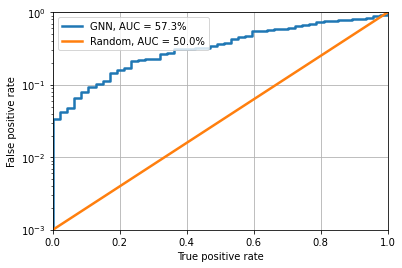

In [230]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# create ROC curves
fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test[:,1], y_predict[:,1])
    
# plot ROC curves
plt.figure()
plt.plot(tpr_gnn, fpr_gnn, lw=2.5, label="GNN, AUC = {:.1f}%".format(auc(fpr_gnn,tpr_gnn)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001,1)
plt.xlim(0,1)
plt.plot([0, 1], [0.001, 1], lw=2.5, label='Random, AUC = 50.0%')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [233]:
import uproot
n_events=1000
raw_path = '/teams/DSC180A_FA20_A00/b06particlephysics/train/ntuple_merged_10.root'
root_file = uproot.open(raw_path)

tree = root_file['deepntuplizer/tree']

feature_array = tree.arrays(branches=features,
                                        entrystop=n_events,
                                        namedecode='utf-8')

label_array_all = tree.arrays(branches=labels,
                                          entrystop=n_events,
                                          namedecode='utf-8')
            
n_samples = label_array_all[labels[0]].shape[0]

In [234]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#used in src/model/baseline_model.py, src/model/model.py, and src/analysis/compare.py
def visualize(name, test=False):
    
    if test:
        vis_path = 'test/'
    else:
        vis_path = 'data/visualizations/'
    
    plt.savefig(vis_path + name)
    
    return None

#used in src/model/baseline_model.py, src/model/model.py
def visualize_loss(model):
    
    plt.figure()
    plt.plot(model.history['loss'],label='Loss')
    plt.plot(model.history['val_loss'],label='Val. loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    return None

#used in src/analysis/compare.py
def visualize_roc_compare(fpr, tpr):
    
    plt.figure()
    plt.plot(fpr, tpr, lw=2.5, label="AUC = {:.1f}%".format(auc(fpr,tpr)*100))
    plt.xlabel(r'False positive rate')
    plt.ylabel(r'True positive rate')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.plot([0, 1], [0, 1], lw=2.5, label='Random, AUC = 50.0%')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.show()
    
    return None

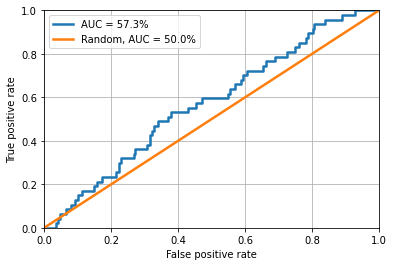

In [235]:
visualize_roc_compare(fpr_gnn, tpr_gnn)

In [236]:
fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test[:,1], y_predict[:,1])

In [248]:
# let's check what is a "t" in the following:
for t1 in test_dataset:
    break
    
print('Bad format:', t1)

# this is not the correct format to feed to the model
# REMEMBER: we always feed a loader as follows:

for t2 in test_loader:
    break

print('Good format:', t2)            # this is the format our model accepts
                                    # a forward pass (prediction) is simply: model(t.x , t.edge_index, t.batch)

Bad format: [Data(edge_index=[2, 930], u=[1, 2], x=[31, 48], y=[1, 6])]
Good format: Batch(batch=[840], edge_index=[2, 23038], u=[32, 2], x=[840, 48], y=[32, 6])


In [252]:
# COMPARING MODELS
predict_array_gnn = []
label_array_test = []

for t in test_loader:
    label_array_test.append(t)
    predict_array_gnn.append(model(t.x , t.edge_index, t.batch))


predict_array_dnn = np.concatenate(predict_array_dnn,axis=0)
predict_array_cnn = np.concatenate(predict_array_cnn,axis=0)
label_array_test = np.concatenate(label_array_test,axis=0)

fpr_dnn = []
tpr_dnn = []
fpr_cnn = []
tpr_cnn = []
nlabels = 6

# create ROC curves for each class
for i in range(nlabels):
    t_fpr_d, t_tpr_d, thresh_d = roc_curve(label_array_test[:,i], predict_array_gnn[:,i])
        
    #appending
    fpr_dnn.append(t_fpr_d)
    tpr_dnn.append(t_tpr_d)
    fpr_cnn.append(t_fpr_c)
    tpr_cnn.append(t_tpr_c)

# plot ROC curves
visualize_roc(fpr_cnn, tpr_cnn, fpr_dnn, tpr_dnn, True)

NameError: name 'predict_array_dnn' is not defined

In [12]:
pip install e3nn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 89 kB 8.0 MB/s  eta 0:00:01
     |████████████████████████████████| 16.6 MB 14.4 MB/s eta 0:00:01
     |████████████████████████████████| 5.9 MB 19.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 69.6 MB/s eta 0:00:01
     |████████████████████████████████| 512 kB 31.9 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 60.4 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 2.5 MB/s  eta 0:00:01
     |████████████████████████████████| 295 kB 69.6 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 82.8 MB/s eta 0:00:01
     |████████████████████████████████| 246 kB 79.6 MB/s eta 0:00:01
     |████████████████████████████████| 578 kB 73.5 MB/s eta 0:00:01
  Created wheel for pymatgen: filename=pymatgen-2020.12.31-cp38-cp38-linux_x86_64.whl size=4182894 sha256=9bee9829d2e36cf830a24ec266383f62ec379a5ddb7d162f54d31307a6

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.
